In [1]:
import networkx as nx
import pandas as pd
import os

In [2]:
#https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gat-node-classification.html

In [3]:
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

2022-03-20 22:39:56.563951: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-03-20 22:39:57.343813: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-03-20 22:39:57.400038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-20 22:39:57.400530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-20 22:39:57.400562: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10

In [4]:
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [6]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [7]:
set(node_subjects)

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In [8]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [9]:
from collections import Counter
Counter(train_subjects)

Counter({'Genetic_Algorithms': 22,
         'Case_Based': 16,
         'Theory': 18,
         'Neural_Networks': 42,
         'Reinforcement_Learning': 11,
         'Probabilistic_Methods': 22,
         'Rule_Learning': 9})

In [10]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [11]:
generator = FullBatchNodeGenerator(G, method="gat")

In [12]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [13]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [14]:
x_inp, predictions = gat.in_out_tensors()

In [15]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [16]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [18]:
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/50


2022-03-20 22:40:21.622900: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


1/1 - 0s - loss: 1.9980 - acc: 0.1429 - val_loss: 1.8360 - val_acc: 0.3940
Epoch 2/50
1/1 - 0s - loss: 1.8264 - acc: 0.2857 - val_loss: 1.7352 - val_acc: 0.4660
Epoch 3/50
1/1 - 0s - loss: 1.7271 - acc: 0.4429 - val_loss: 1.6484 - val_acc: 0.4920
Epoch 4/50
1/1 - 0s - loss: 1.5909 - acc: 0.4929 - val_loss: 1.5697 - val_acc: 0.5080
Epoch 5/50
1/1 - 0s - loss: 1.4756 - acc: 0.5786 - val_loss: 1.4980 - val_acc: 0.5320
Epoch 6/50
1/1 - 0s - loss: 1.4237 - acc: 0.5500 - val_loss: 1.4315 - val_acc: 0.5640
Epoch 7/50
1/1 - 0s - loss: 1.3027 - acc: 0.5500 - val_loss: 1.3688 - val_acc: 0.5880
Epoch 8/50
1/1 - 0s - loss: 1.2984 - acc: 0.5786 - val_loss: 1.3091 - val_acc: 0.6060
Epoch 9/50
1/1 - 0s - loss: 1.1800 - acc: 0.6714 - val_loss: 1.2513 - val_acc: 0.6440
Epoch 10/50
1/1 - 0s - loss: 1.0454 - acc: 0.6857 - val_loss: 1.1959 - val_acc: 0.6700
Epoch 11/50
1/1 - 0s - loss: 1.1081 - acc: 0.6643 - val_loss: 1.1450 - val_acc: 0.7260
Epoch 12/50
1/1 - 0s - loss: 0.9988 - acc: 0.7286 - val_loss: 1

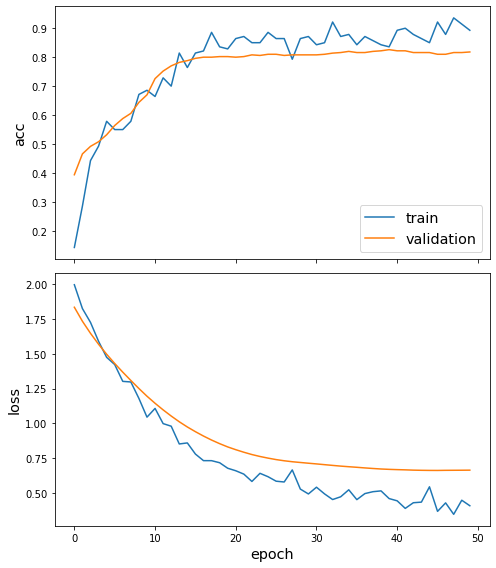

In [19]:
sg.utils.plot_history(history)

In [20]:
model.load_weights("logs/best_model.h5")

In [21]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 1ms/step - loss: 0.6330 - acc: 0.8162

Test Set Metrics:
	loss: 0.6330
	acc: 0.8162


In [22]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [23]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [24]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Theory,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Case_Based,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


In [25]:
emb_layer = next(l for l in model.layers if l.name.startswith("graph_attention"))
print(
    "Embedding layer: {}, output shape {}".format(emb_layer.name, emb_layer.output_shape)
)

Embedding layer: graph_attention_sparse, output shape (1, 2708, 64)


In [26]:
embedding_model = Model(inputs=x_inp, outputs=emb_layer.output)

In [27]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 64)

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [29]:
X = emb.squeeze()
y = np.argmax(target_encoding.transform(node_subjects), axis=1)

In [30]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(G.nodes()))
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y


/opt/miniconda3/envs/gnn/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/miniconda3/envs/gnn/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


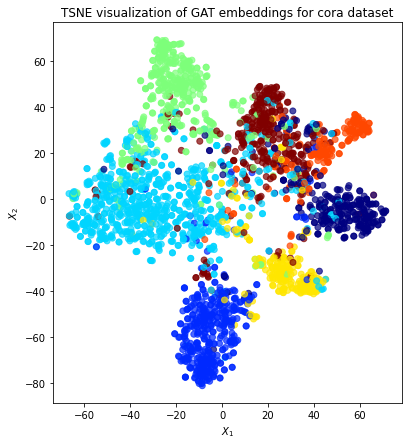

In [31]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GAT embeddings for cora dataset".format(transform.__name__)
)
plt.show()